In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pickle
import numpy as np

import crflux.models as pm
import mceq_underground_helpers_cs as mh
from MCEq.data import InteractionCrossSections
from MCEq.core import MCEqRun
import  mceq_underground_helper_k_pi as helper
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [2]:
X = helper.slant_depths[2:-1:4]

In [3]:
plot_dir = '/hetghome/khymon/Plots/cs-analysis/'

In [4]:
cs_p_values = [1.0,1.01] #[0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]  # List of cross-section values: pion-air
cs_k_values = [1.00]
ptype_values = [2212] 
season_values = ["jan", "apr", "jul"]  #  seasons
e0_values = [2.05,2.15,2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85]
e1_values = [2.25,2.35,2.45,2.55,2.65,2.75,2.85,2.95,3.05,3.15,3.25,3.35,3.45,3.55,3.65,3.75,3.85,3.95,4.05,4.15,4.25,4.35,4.45,4.55,4.65,4.75,4.85,4.95,5.05]
e_center = e0_values + np.ones(len(e0_values))*0.1
pairwise = True


helper.initialize_flux_dicts(
        ptype_values, cs_p_values, cs_k_values, e0_values, e1_values if 'e1_values' in locals() else [None], pairwise=pairwise
) 

helper.some_function_that_uses_angles()
angles = helper.angles
X = helper.slant_depths[2:-1:4]

Key: (2212, 1.0, 1.0, 2.05, 'inf')
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.05, 2.25)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.15, 2.35)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.25, 2.45)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.35, 2.55)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for season apr: (6, 121)
Shape of flux for season jul: (6, 121)
Key: (2212, 1.01, 1.0, 2.45, 2.65)
Length of cos_thetas: 6
Shape of flux for season jan: (6, 121)
Shape of flux for seas

In [5]:
cs_p = 1.01
cs_k = 1.0
angle = 0.0
season = "apr"

In [6]:
def get_log_y(X, angle,cs_p,cs_k,e0,e1,season):
    log_y = np.log10(1e4*helper.mult_dist(X,
                            angle,
                            pm.GlobalSplineFitBeta(),"yields_" + season,
                            2212,
                            cs_p, cs_k,e0,e1,
                            norm=False#))[0]
                        ) / helper.rates(X, angle, season, 2212, cs_p, cs_k, e0,e1))

    return log_y

In [44]:
def get_derivative(x_log, log_y):

    deriv_low = (log_y[19] - log_y[1])/(np.log10(x_log[19])-np.log10(x_log[1])) 
    deriv_high = (log_y[99] - log_y[59])/(np.log10(x_log[99])-np.log10(x_log[59])) 

    return np.array([deriv_low, deriv_high])


In [8]:
x_log = np.log10(helper.n_mu_vec)

In [9]:
y_log_test = get_log_y(X[0], angle, cs_p, cs_k ,3.25,3.45,"apr")

In [22]:
deriv_mod_15 =np.ndarray(shape=(len(e0_values),2))
deriv_mod_35 =np.ndarray(shape=(len(e0_values),2))
for en in range(len(e0_values)):
    logy_15 = get_log_y(X[0], angle, cs_p, cs_k ,e0_values[en],e1_values[en],season)
    deriv_mod_15[en] = get_derivative(x_log, logy_15)

    logy_35 = get_log_y(X[1], angle, cs_p, cs_k ,e0_values[en],e1_values[en],season)
    deriv_mod_35[en] = get_derivative(x_log, logy_35)

y_log_def_15 = get_log_y(X[0], angle, 1.0, cs_k ,2.05,"inf",season)
deriv_def_15 = get_derivative(x_log, y_log_def_15)

y_log_def_35 = get_log_y(X[1], angle, 1.0, cs_k ,2.05,"inf",season)
deriv_def_35 = get_derivative(x_log, y_log_def_35)


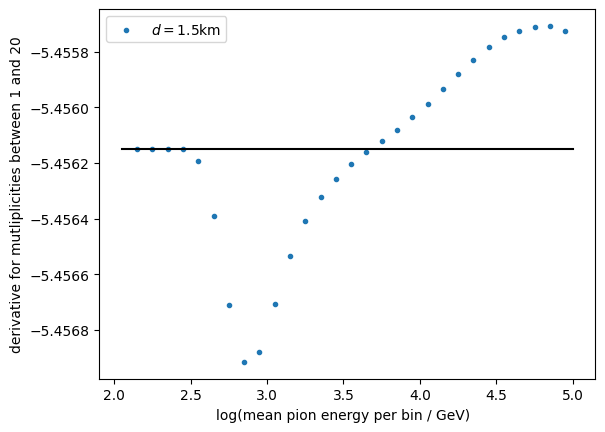

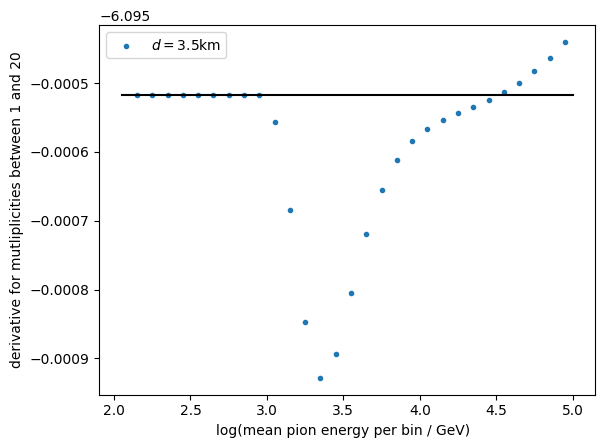

<Figure size 640x480 with 0 Axes>

In [24]:
plt.scatter(e_center,deriv_mod_15[:,0],label="$d=1.5$km",marker='.')
plt.plot([2.05,5],[deriv_def_15[0],deriv_def_15[0]],color='black')
plt.ylabel('derivative for mutliplicities between 1 and 20')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_lowregion_ebin_d15km.png')
plt.show()
plt.clf()

plt.scatter(e_center,deriv_mod_35[:,0],label="$d=3.5$km",marker='.')
plt.plot([2.05,5],[deriv_def_35[0],deriv_def_35[0]],color='black')
plt.ylabel('derivative for mutliplicities between 1 and 20')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_lowregion_ebin_d35km.png')
plt.show()
plt.clf()

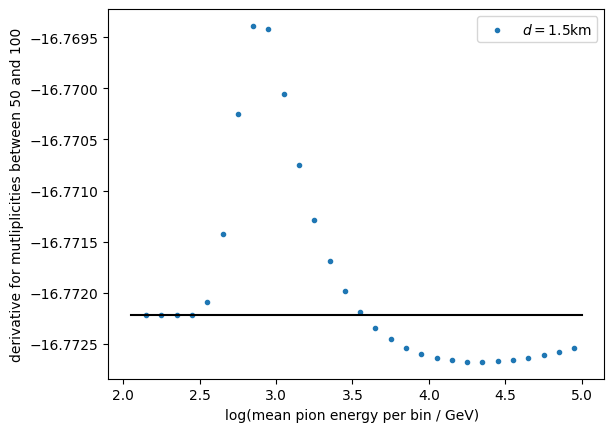

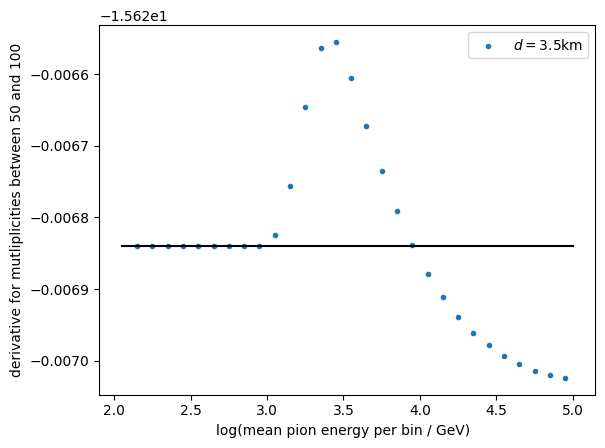

<Figure size 640x480 with 0 Axes>

In [25]:
plt.scatter(e_center,deriv_mod_15[:,1],label="$d=1.5$km",marker='.')
plt.plot([2.05,5],[deriv_def_15[1],deriv_def_15[1]],color='black')
plt.ylabel('derivative for mutliplicities between 50 and 100')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_highregion_ebin_d15.png')
plt.show()
plt.clf()

plt.scatter(e_center,deriv_mod_35[:,1],label="$d=3.5$km",marker='.')
plt.plot([2.05,5],[deriv_def_35[1],deriv_def_35[1]],color='black')
plt.ylabel('derivative for mutliplicities between 50 and 100')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_highregion_ebin_d35.png')
plt.show()
plt.clf()

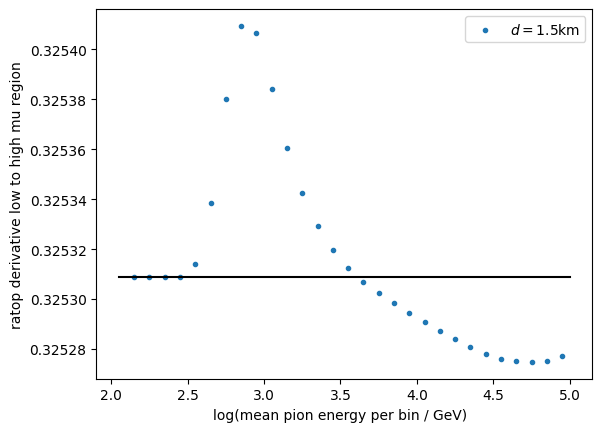

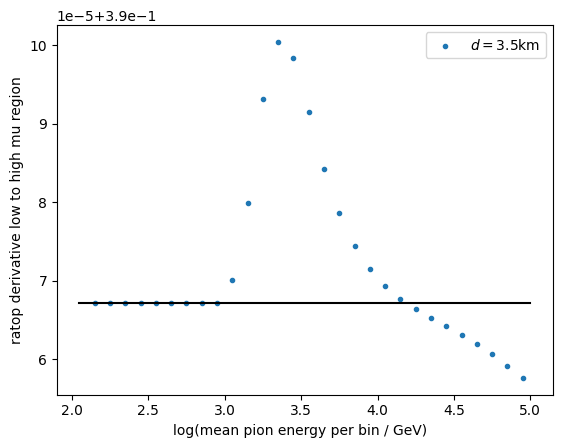

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.scatter(e_center,deriv_mod_15[:,0]/deriv_mod_15[:,1],label="$d=1.5$km",marker='.')
plt.plot([2.05,5],[deriv_def_15[0]/deriv_def_15[1],deriv_def_15[0]/deriv_def_15[1]],color='black')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_ratio_ebin_d15.png')
plt.show()
plt.clf()


plt.scatter(e_center,deriv_mod_35[:,0]/deriv_mod_35[:,1],label="$d=3.5$km",marker='.')
plt.plot([2.05,5],[deriv_def_35[0]/deriv_def_35[1],deriv_def_35[0]/deriv_def_35[1]],color='black')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_ratio_ebin_d35.png')
plt.show()
plt.clf()

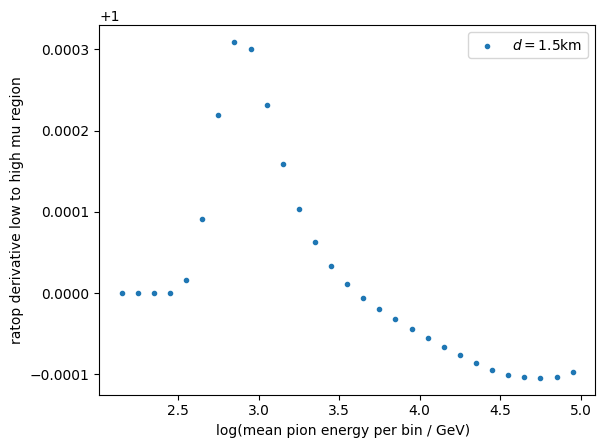

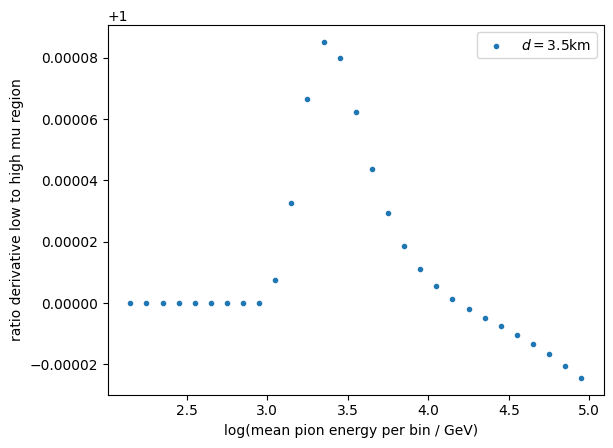

<Figure size 640x480 with 0 Axes>

In [28]:
def_ratio_15 = np.ones(len(e_center))* (deriv_def_15[0]/deriv_def_15[1])
def_ratio_35 = np.ones(len(e_center))* (deriv_def_35[0]/deriv_def_35[1])


plt.scatter(e_center,(deriv_mod_15[:,0]/deriv_mod_15[:,1])/def_ratio_15,label="$d=1.5$km",marker='.')
plt.ylabel('ratop derivative low to high mu region')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_ratio-to-def_ebin_d15.png')
plt.show()
plt.clf()


plt.scatter(e_center,(deriv_mod_35[:,0]/deriv_mod_35[:,1])/def_ratio_35,label="$d=3.5$km",marker='.')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_ratio-to-def_ebin_d35png')
plt.show()
plt.clf()

In [29]:
# study in depenendence of slant depth

In [32]:
def sl_depth(d,angle):
    return d/np.cos(np.deg2rad(angle))
    

In [37]:
sl = sl_depth(1.5,angles)


In [47]:
# calculate derivative, keep angle at 0 (either change angle or slant depth)

deriv_mod_sl =np.ndarray(shape=(len(sl),len(e0_values),2))
deriv_def_sl = np.ndarray(shape=(len(sl),2))

for s in range(len(sl)):    

    y_log_def_sl = get_log_y(sl[s], angle, 1.0, cs_k ,2.05,"inf",season)
    deriv_def_sl[s] = get_derivative(x_log, y_log_def_sl)

    for en in range(len(e0_values)):
        logy_mod = get_log_y(sl[s], angle, cs_p, cs_k ,e0_values[en],e1_values[en],season)
        deriv_mod_sl[s][en] = get_derivative(x_log, logy_mod)




In [49]:
deriv_def_sl

array([[ -6.03250639, -15.74069646],
       [ -5.8898371 , -15.73265743],
       [ -5.72720119, -15.67540793],
       [ -5.59775517, -15.9595075 ],
       [ -5.50915906, -16.32366867],
       [ -5.45615023, -16.77221954]])

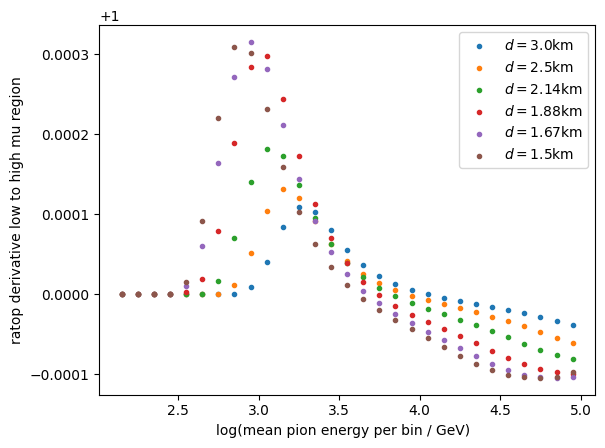

<Figure size 640x480 with 0 Axes>

In [55]:


for s in range(len(sl)):
    def_ratio_sl = np.ones(len(e_center))* (deriv_def_sl[s][0]/deriv_def_sl[s][1])

    plt.scatter(e_center,(deriv_mod_sl[s,:,0]/deriv_mod_sl[s,:,1])/def_ratio_sl,label="$d=$" +str(np.round(sl[s],decimals=2)) + "km",marker='.')
plt.ylabel('ratop derivative low to high mu region')
plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_ratio-to-def_ebin_slantdepth.png')
plt.show()
plt.clf()




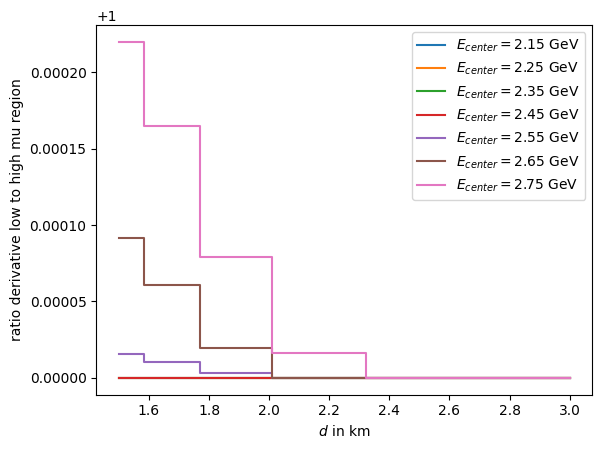

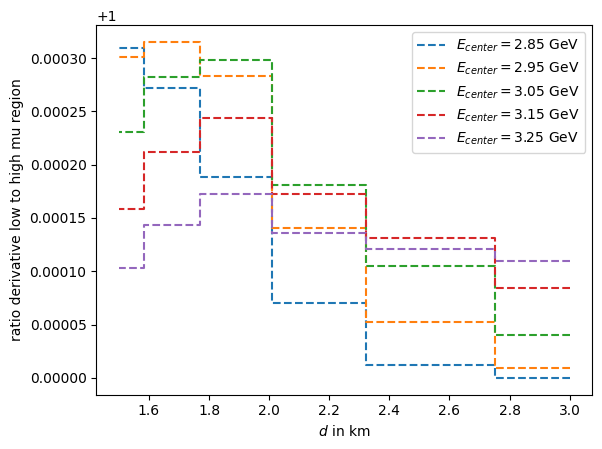

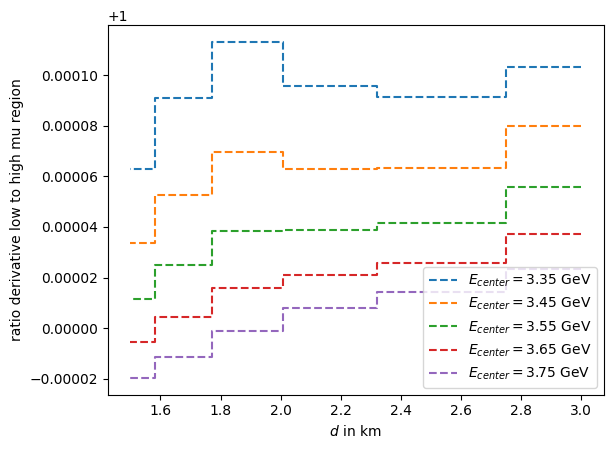

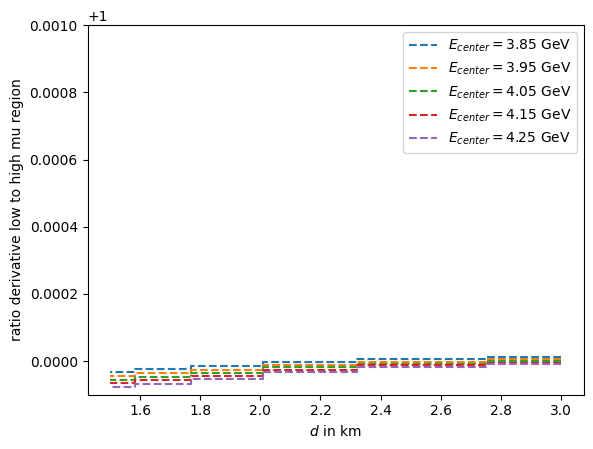

<Figure size 640x480 with 0 Axes>

In [ ]:

def_ratio_sl = np.ones(len(sl))* (deriv_def_sl[:,0]/deriv_def_sl[:,1])

for en in range(len(e_center[0:7])):
    
    plt.plot(sl,(deriv_mod_sl[:,en,0]/deriv_mod_sl[:,en,1])/def_ratio_sl,label="$E_{center}=$" + str(np.round(e_center[en],decimals=2)) + " GeV",drawstyle='steps-mid')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('$d$ in km')


#plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_ratio-to-def_slantdepth_ebin_bin1-7.png')
plt.show()
plt.clf()

for en in range(len(e_center[0:5])):
    
    plt.plot(sl,(deriv_mod_sl[:,en+7,0]/deriv_mod_sl[:,en+7,1])/def_ratio_sl,label="$E_{center}=$" + str(np.round(e_center[en+7],decimals=2)) + " GeV",drawstyle='steps-mid',ls='--')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('$d$ in km')


#plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_ratio-to-def_slantdepth_ebin_bin8-12.png')
plt.show()
plt.clf()

for en in range(len(e_center[0:5])):
    
    plt.plot(sl,(deriv_mod_sl[:,en+12,0]/deriv_mod_sl[:,en+12,1])/def_ratio_sl,label="$E_{center}=$" + str(np.round(e_center[en+12],decimals=2)) + " GeV",drawstyle='steps-mid',ls='--')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('$d$ in km')


#plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_ratio-to-def_slantdepth_ebin_bin12-17.png')
plt.show()
plt.clf()


for en in range(len(e_center[0:5])):
    
    plt.plot(sl,(deriv_mod_sl[:,en+17,0]/deriv_mod_sl[:,en+17,1])/def_ratio_sl,label="$E_{center}=$" + str(np.round(e_center[en+17],decimals=2)) + " GeV",drawstyle='steps-mid',ls='--')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('$d$ in km')

plt.ylim([0.99990,1.0010])
#plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_ratio-to-def_slantdepth_ebin_bin17-22.png')
plt.show()
plt.clf()

for en in range(len(e_center[0:5])):
    
    plt.plot(sl,(deriv_mod_sl[:,en+22,0]/deriv_mod_sl[:,en+22,1])/def_ratio_sl,label="$E_{center}=$" + str(np.round(e_center[en+22],decimals=2)) + " GeV",drawstyle='steps-mid',ls='--')
plt.ylabel('ratio derivative low to high mu region')
plt.xlabel('$d$ in km')


#plt.xlabel('log(mean pion energy per bin / GeV)  ')
plt.legend()
plt.savefig(plot_dir + 'cs_p_energybintest_powerlawderiv_ratio-to-def_slantdepth_ebin_bin22-27.png')

plt.ylim([0.99990,1.0010])
plt.clf()
plt.show()






In [72]:
(deriv_mod_sl[:,15,0]/deriv_mod_sl[:,15,1])/def_ratio_sl

array([1.00003707, 1.0000258 , 1.00002114, 1.00001575, 1.0000046 ,
       0.99999444])